$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\Yv}{\mathbf{Y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\gv}{\mathbf{g}}
\newcommand{\Hv}{\mathbf{H}}
\newcommand{\dv}{\mathbf{d}}
\newcommand{\Vv}{\mathbf{V}}
\newcommand{\vv}{\mathbf{v}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\Zv}{\mathbf{Z}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}
\newcommand{\dimensionbar}[1]{\underset{#1}{\operatorname{|}}}
$

# Nonlinear Regression with Neural Networks

One way to start thinking about neural networks is that they are just one way to fit a non-linear model to some data.  Neural nets are used for both regression and classification in supervised learning as well as for various types of unsupervised learning such as auto encoders and Restricted Boltzmann Machines.  In developing the math to fit a neural network (NN), it helps to start the discussion with a good picture:

<img src="https://cdn.rawgit.com/MichaelSzczepaniak/WonderfulML/master/docs/graphics/regression_ff_nn.svg">

Because we are typically dealing with large numbers of parameters in these types of modes, it is necessary to think in terms of matrices.  In Figure 2. above, the shape of each matrix is shown at the bottom of the diagram.  As we'll say as we continue to work with these systems, it's very important to keep these shapes in mind especially when debugging code that computes the weights.

The derivation of the forward and backward passes through the network can be found [in this notebook](https://cdn.rawgit.com/MichaelSzczepaniak/WonderfulML/master/docs/tbd_gradient_derivation.ipynb).  Here is a summary of the results of the derivation.

The forward pass math:

$$
    \begin{align*}
      \Zv &= h(\tilde{\Xv} \Vv)\\
      \Yv &= \tilde{\Zv} \Wv\\
    \end{align*}
$$

The backward pass math:

$$
     \begin{align*}
       \Vv & \leftarrow \Vv + \rho_h \frac{1}{N} \frac{1}{K} \tilde{\Xv}^T \left ( (\Tv - \Yv) \hat{\Wv}^T \cdot  (1-\Zv^2) \right )\\
      \Wv & \leftarrow \Wv + \rho_o \frac{1}{N}  \frac{1}{K}\tilde{\Zv}^T (\Tv - \Yv)
     \end{align*}
$$

The tilde over the inputs $\tilde{\Xv}$ and $\tilde{\Zv}$ are the inputs to the input and hidden layers augmented with the constant 1 respectively.

### A Simple Example

Let's fit a neural net to a simple function:

$$
f(x) = 0.2 + 0.05 (x+10) + 0.4 \sin(x+10)) + 0.2 \epsilon
$$

We'll add a little noise gaussian noise with the $\epsilon$ term which is a random variable drawn from the standard normal distribution with mean of 0 and standard deviation of 1, or $\epsilon \sim \mathcal{N}(0,1)$, and $x \in [-10,10]$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import IPython.display as ipd  # for display and clear_output
import time  # for sleep

In [2]:
a = np.array([1,2,3,4,5,6])
m1_3x2 = a.reshape(3,2)
m2_2x4 = np.array([2,4,5,6,1,3,5,7]).reshape(2,4)
np.dot(m1_3x2, m2_2x4)

array([[ 4, 10, 15, 20],
       [10, 24, 35, 46],
       [16, 38, 55, 72]])

In [3]:
m1_3x2

array([[1, 2],
       [3, 4],
       [5, 6]])

In [4]:
# Make some training data
def get_test_data(x_1d):
    data = 0.2 + 0.05 * (x_1d + 10) + 0.4 * np.sin(x_1d + 10)
    return(data)
np.random.seed(711)  # for repeatablity
n = 21  # number of points to plot
x_train = np.linspace(0., n-1, n).reshape((n, 1)) - 10  # same as matrix(-10:10, nrow = 21) in R
t_true = get_test_data(x_train)  # true function to fit
t_train = t_true + 0.2 * np.random.normal(size=(n,1))  # train on noise version of true function

# Make some testing data
x_test = x_train + 0.1 * np.random.normal(size=(n, 1))
t_test = get_test_data(x_test) + 0.2 * np.random.normal(size=(n, 1))

nSamples = x_train.shape[0]
nOutputs = t_train.shape[1]

print(nSamples, nOutputs)

21 1


In [5]:
# https://stats.stackexchange.com/questions/47590/what-are-good-initial-weights-in-a-neural-network


In [7]:
import numpy as np
import sys
# https://stackoverflow.com/questions/4383571/importing-files-from-different-folder
sys.path.insert(0, '../../Python/')
import scaledconjugategradient as scg
import mlutils as ml  # for draw()
from copy import copy

# Adapted from Chuck Anderson
class NeuralNetwork:

    def __init__(self, ni,nhs,no):        
        try:
            nihs = [ni] + list(nhs)
        except:
            nihs = [ni] + [nhs]
            nhs = [nhs]
        self.Vs = [1/np.sqrt(nihs[i])*
                   np.random.uniform(-1,1,size=(1+nihs[i],nihs[i+1])) for i in range(len(nihs)-1)]
        self.W = 1/np.sqrt(nhs[-1])*np.random.uniform(-1,1,size=(1+nhs[-1],no))
        self.ni,self.nhs,self.no = ni,nhs,no
        self.Xmeans = None
        self.Xstds = None
        self.Tmeans = None
        self.Tstds = None
        self.trained = False
        self.reason = None
        self.errorTrace = None
        self.numberOfIterations = None

    def __repr__(self):
        str = 'NeuralNetwork({}, {}, {})'.format(self.ni,self.nhs,self.no)
        # str += '  Standardization parameters' + (' not' if self.Xmeans == None else '') + ' calculated.'
        if self.trained:
            str += '\n   Network was trained for {} iterations. Final error is {}.'.format(self.numberOfIterations,
                                                                                           self.errorTrace[-1])
        else:
            str += '  Network is not trained.'
        return str
            
    def standardizeX(self,X):
        result = (X - self.Xmeans) / self.XstdsFixed
        result[:,self.Xconstant] = 0.0
        return result
    def unstandardizeX(self,Xs):
        return self.Xstds * Xs + self.Xmeans
    def standardizeT(self,T):
        result = (T - self.Tmeans) / self.TstdsFixed
        result[:,self.Tconstant] = 0.0
        return result
    def unstandardizeT(self,Ts):
        return self.Tstds * Ts + self.Tmeans
   
    def train(self,X,T,nIterations=100,verbose=False,
              weightPrecision=0,errorPrecision=0):
        
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xconstant = self.Xstds == 0
            self.XstdsFixed = copy(self.Xstds)
            self.XstdsFixed[self.Xconstant] = 1
        X = self.standardizeX(X)

        if T.ndim == 1:
            T = T.reshape((-1,1))

        if self.Tmeans is None:
            self.Tmeans = T.mean(axis=0)
            self.Tstds = T.std(axis=0)
            self.Tconstant = self.Tstds == 0
            self.TstdsFixed = copy(self.Tstds)
            self.TstdsFixed[self.Tconstant] = 1
        T = self.standardizeT(T)

        # Local functions used by scg()

        def pack(Vs,W):
            return np.hstack([V.flat for V in Vs] + [W.flat])

        def unpack(w):
            first = 0
            numInThisLayer = self.ni
            for i in range(len(self.Vs)):
                self.Vs[i][:] = w[first:first+(numInThisLayer+1)*self.nhs[i]].reshape((numInThisLayer+1,self.nhs[i]))
                first += (numInThisLayer+1) * self.nhs[i]
                numInThisLayer = self.nhs[i]
            self.W[:] = w[first:].reshape((numInThisLayer+1,self.no))

        def objectiveF(w):
            unpack(w)
            Zprev = X
            for i in range(len(self.nhs)):
                V = self.Vs[i]
                Zprev = np.tanh(np.dot(Zprev,V[1:,:]) + V[0:1,:])  # handling bias weight without adding column of 1's
            Y = np.dot(Zprev, self.W[1:,:]) + self.W[0:1,:]
            return np.mean((T-Y)**2)

        def gradF(w):
            unpack(w)
            Zprev = X
            Z = [Zprev]
            for i in range(len(self.nhs)):
                V = self.Vs[i]
                Zprev = np.tanh(np.dot(Zprev,V[1:,:]) + V[0:1,:])
                Z.append(Zprev)
            Y = np.dot(Zprev, self.W[1:,:]) + self.W[0:1,:]
            delta = -(T - Y) / (X.shape[0] * T.shape[1])
            dW = 2 * np.vstack((np.dot(np.ones((1,delta.shape[0])),delta),  np.dot( Z[-1].T, delta)))
            dVs = []
            delta = (1-Z[-1]**2) * np.dot( delta, self.W[1:,:].T)
            for Zi in range(len(self.nhs),0,-1):
                Vi = Zi - 1 # because X is first element of Z
                dV = 2 * np.vstack(( np.dot(np.ones((1,delta.shape[0])), delta),
                                 np.dot( Z[Zi-1].T, delta)))
                dVs.insert(0,dV)
                delta = np.dot( delta, self.Vs[Vi][1:,:].T) * (1-Z[Zi-1]**2)
            return pack(dVs,dW)

        scgresult = scg.scg(pack(self.Vs,self.W), objectiveF, gradF,
                            xPrecision = weightPrecision,
                            fPrecision = errorPrecision,
                            nIterations = nIterations,
                            verbose=verbose,
                            ftracep=True)

        unpack(scgresult['x'])
        self.reason = scgresult['reason']
        self.errorTrace = np.sqrt(scgresult['ftrace']) # * self.Tstds # to unstandardize the MSEs
        self.numberOfIterations = len(self.errorTrace)
        self.trained = True
        return self

    def use(self,X,allOutputs=False):
        Zprev = self.standardizeX(X)
        Z = [Zprev]
        for i in range(len(self.nhs)):
            V = self.Vs[i]
            Zprev = np.tanh(np.dot(Zprev,V[1:,:]) + V[0:1,:])
            Z.append(Zprev)
        Y = np.dot(Zprev, self.W[1:,:]) + self.W[0:1,:]
        Y = self.unstandardizeT(Y)
        return (Y,Z[1:]) if allOutputs else Y

    def getNumberOfIterations(self):
        return self.numberOfIterations
    
    def getErrors(self):
        return self.errorTrace
        
    def draw(self,inputNames = None, outputNames = None):
        ml.draw(self.Vs, self.W, inputNames, outputNames)

SCG stopped after 1001 iterations: did not converge
Final RMSE: train 0.00411279186107 test 2.99724642631


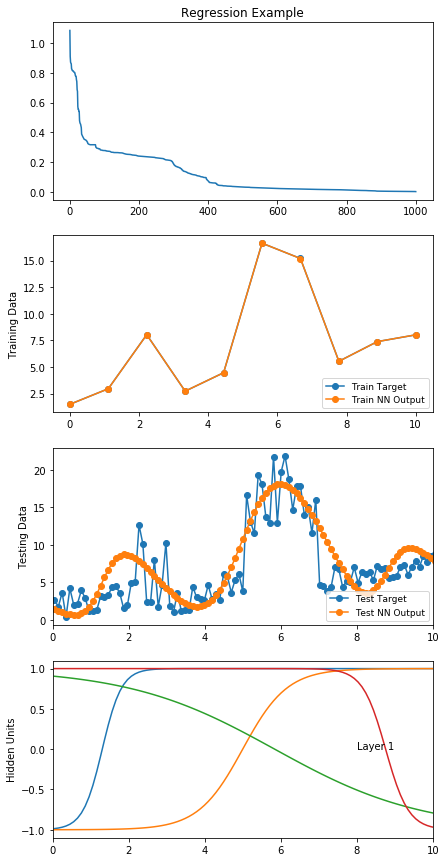

In [8]:
import neuralnetworks as nn
import imp
imp.reload(nn)

nSamples = 10
X = np.linspace(0,10,nSamples).reshape((-1,1))
T = 1.5 + 0.6 * X + 0.8 * np.sin(1.5*X)
T[np.logical_and(X > 2, X < 3)] *= 3
T[np.logical_and(X > 5, X < 7)] *= 3

nSamples = 100
Xtest = np.linspace(0,10,nSamples).reshape((-1,1)) + 10.0/nSamples/2
Ttest = 1.5 + 0.6 * Xtest + 0.8 * np.sin(1.5*Xtest) + np.random.uniform(-2,2,size=(nSamples,1))
Ttest[np.logical_and(Xtest > 2, Xtest < 3)] *= 3
Ttest[np.logical_and(Xtest > 5,Xtest < 7)] *= 3

nnet = nn.NeuralNetwork(1,4,1)

nnet.train(X,T,errorPrecision=1.e-10,weightPrecision=1.e-10,nIterations=1000)
print("SCG stopped after",nnet.getNumberOfIterations(),"iterations:",nnet.reason)
Y = nnet.use(X)
Ytest,Ztest = nnet.use(Xtest, allOutputs=True)
print("Final RMSE: train", np.sqrt(np.mean((Y-T)**2)),"test",np.sqrt(np.mean((Ytest-Ttest)**2)))

plt.figure(figsize=(15,15))

nHLayers = len(nnet.nhs)
nPlotRows = 3 + nHLayers

plt.subplot(nPlotRows,2,1)
plt.plot(nnet.getErrors())
plt.title('Regression Example')
plt.subplot(nPlotRows,2,3)
plt.plot(X,T,'o-')
plt.plot(X,Y,'o-')
plt.ylabel('Training Data')
plt.legend(('Train Target','Train NN Output'),loc='lower right', prop={'size':9})
plt.subplot(nPlotRows,2,5)
plt.plot(Xtest,Ttest,'o-')
plt.plot(Xtest,Ytest,'o-')
plt.ylabel('Testing Data')
plt.xlim(0,10)
plt.legend(('Test Target','Test NN Output'),loc='lower right', prop={'size':9})
for i in range(nHLayers):
    layer = nHLayers-i-1
    plt.subplot(nPlotRows,2,i*2+7)
    plt.plot(Xtest,Ztest[layer])
    plt.xlim(0,10)
    plt.ylim(-1.1,1.1)
    plt.ylabel('Hidden Units')
    plt.text(8,0, 'Layer {}'.format(layer+1))

### Reference
[1] Acknowledgement to [Dr. Chuck Anderson at Colorado State University](http://www.cs.colostate.edu/~anderson/newsite/) for introducing me to this way of thinking about neural nets and provided the SCG code.  
[2]  
[3]